## 감정분류 -> 언어 표현

In [1]:
import math
import numpy as np
import pandas as pd
import random
import re
import torch
import urllib.request
from torch.utils.data import DataLoader, Dataset
from transformers import PreTrainedTokenizerFast

In [2]:
Q_TKN = "<usr>"
A_TKN = "<sys>"
BOS = '</s>'
EOS = '</s>'
MASK = '<unused0>'
SENT = '<unused1>'
PAD = '<pad>'

In [3]:
Chatbot_Data = pd.read_csv("ChatBotData1.csv")
print(Chatbot_Data.shape)

Chatbot_Data.head()

(107, 3)


,Q,A,label
0,화남,분노의 엉덩이댄스!!,3.0
1,화남,화날땐 부리부리~,3.0
2,화남,화날땐 하나둘셋 야!,3.0
3,화남,우이씨,3.0
4,화남,뚜씨 뚜씨,3.0


In [4]:
BOS = "</s>"
EOS = "</s>"
PAD = "<pad>"
MASK = "<unused0>"

# 허깅페이스 transformers 에 등록된 사전 학습된 koGTP2 토크나이저를 가져온다.
koGPT2_TOKENIZER = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2", bos_token=BOS, eos_token=EOS, unk_token="<unk>", pad_token=PAD, mask_token=MASK,)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [5]:
# 챗봇 데이터를 처리하는 클래스
class ChatbotDataset(Dataset):
    def __init__(self, chats, max_len=10):  # 데이터셋의 전처리를 해주는 부분
        self._data = chats
        self.max_len = max_len
        self.q_token = Q_TKN
        self.a_token = A_TKN
        self.sent_token = SENT
        self.eos = EOS
        self.mask = MASK
        self.tokenizer = koGPT2_TOKENIZER

    def __len__(self):  # chatbotdata 의 길이를 리턴한다.
        return len(self._data)

    def __getitem__(self, idx):  # 로드한 챗봇 데이터를 차례차례 DataLoader로 넘겨주는 메서드
        turn = self._data.iloc[idx]
        q = turn["Q"]  # 질문을 가져온다.
        q = re.sub(r"([?.!,])", r" ", q)  # 구둣점들을 제거한다.

        a = turn["A"]  # 답변을 가져온다.
        a = re.sub(r"([?.!,])", r" ", a)  # 구둣점들을 제거한다.

        q_toked = self.tokenizer.tokenize(self.q_token + q + self.sent_token)
        q_len = len(q_toked)

        a_toked = self.tokenizer.tokenize(self.a_token + a + self.eos)
        a_len = len(a_toked)

        #질문의 길이가 최대길이보다 크면
        if q_len > self.max_len:
            a_len = self.max_len - q_len        #답변의 길이를 최대길이 - 질문길이
            if a_len <= 0:       #질문의 길이가 너무 길어 질문만으로 최대 길이를 초과 한다면
                q_toked = q_toked[-(int(self.max_len / 2)) :]   #질문길이를 최대길이의 반으로 
                q_len = len(q_toked)
                a_len = self.max_len - q_len              #답변의 길이를 최대길이 - 질문길이
            a_toked = a_toked[:a_len]
            a_len = len(a_toked)

        #질문의 길이 + 답변의 길이가 최대길이보다 크면
        if q_len + a_len > self.max_len:
            a_len = self.max_len - q_len        #답변의 길이를 최대길이 - 질문길이
            if a_len <= 0:       #질문의 길이가 너무 길어 질문만으로 최대 길이를 초과 한다면
                q_toked = q_toked[-(int(self.max_len / 2)) :]   #질문길이를 최대길이의 반으로 
                q_len = len(q_toked)
                a_len = self.max_len - q_len              #답변의 길이를 최대길이 - 질문길이
            a_toked = a_toked[:a_len]
            a_len = len(a_toked)

        # 답변 labels = [mask, mask, ...., mask, ..., <bos>,..답변.. <eos>, <pad>....]
        labels = [self.mask,] * q_len + a_toked[1:]

        # mask = 질문길이 0 + 답변길이 1 + 나머지 0
        mask = [0] * q_len + [1] * a_len + [0] * (self.max_len - q_len - a_len)
        # 답변 labels을 index 로 만든다.
        labels_ids = self.tokenizer.convert_tokens_to_ids(labels)
        # 최대길이만큼 PADDING
        while len(labels_ids) < self.max_len:
            labels_ids += [self.tokenizer.pad_token_id]

        # 질문 + 답변을 index 로 만든다.    
        token_ids = self.tokenizer.convert_tokens_to_ids(q_toked + a_toked)
        # 최대길이만큼 PADDING
        while len(token_ids) < self.max_len:
            token_ids += [self.tokenizer.pad_token_id]

        #질문+답변, 마스크, 답변
        return (token_ids, np.array(mask), labels_ids)

In [6]:
# 배치 데이터
def collate_batch(batch):
    data = [item[0] for item in batch]
    mask = [item[1] for item in batch]
    label = [item[2] for item in batch]
    return torch.LongTensor(data), torch.LongTensor(mask), torch.LongTensor(label)

In [7]:
train_set = ChatbotDataset(Chatbot_Data, max_len=40)

#윈도우 환경에서 num_workers 는 무조건 0으로 지정, 리눅스에서는 2
train_dataloader = DataLoader(train_set, batch_size=16, num_workers=0, shuffle=True, collate_fn=collate_batch,)

In [8]:
train_set = ChatbotDataset(Chatbot_Data, max_len=40)

#윈도우 환경에서 num_workers 는 무조건 0으로 지정, 리눅스에서는 2
train_dataloader = DataLoader(train_set, batch_size=16, num_workers=0, shuffle=True, collate_fn=collate_batch,)

In [9]:
for batch_idx, samples in enumerate(train_dataloader):
    token_ids, mask, label = samples

C:\Users\admin\AppData\Local\Temp\ipykernel_24352\2307874980.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:210.)
  return torch.LongTensor(data), torch.LongTensor(mask), torch.LongTensor(label)


### 학습

In [10]:
import numpy as np
import pandas as pd
import torch
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.core.lightning import LightningModule
from torch.utils.data import DataLoader, Dataset
from transformers.optimization import AdamW, get_cosine_schedule_with_warmup
from transformers import PreTrainedTokenizerFast, GPT2LMHeadModel
import re

In [11]:
# 허깅페이스 transformers 에 등록된 사전 학습된 koGTP2 모델과 토크나이저
koGPT2_TOKENIZER = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
            bos_token=BOS, eos_token=EOS, unk_token='<unk>',
            pad_token=PAD, mask_token=MASK) 
model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [12]:
Chatbot_Data = pd.read_csv("ChatBotData1.csv")
print(Chatbot_Data.shape)

Chatbot_Data.head()

(107, 3)


,Q,A,label
0,화남,분노의 엉덩이댄스!!,3.0
1,화남,화날땐 부리부리~,3.0
2,화남,화날땐 하나둘셋 야!,3.0
3,화남,우이씨,3.0
4,화남,뚜씨 뚜씨,3.0


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
device

device(type='cuda')

### 모델 정의

In [38]:
# 관심영역 지정
import cv2
import numpy as np
import matplotlib.pyplot as plt
from fer import FER

def find_emotion(file_path):
    img = cv2.imread(file_path)
    detector = FER()

    # 이미지 감정 분류
    result = detector.detect_emotions(img)
    print(result)
    
    # 가장 높은 점수를 기록한 감정
    emotion, score = detector.top_emotion(img)

    x = result[0]['box'][0]
    y = result[0]['box'][1] 
    w = result[0]['box'][2] 
    h = result[0]['box'][3]
    
    emo_dict = {'angry': '화남', 
            'disgust': '역겨움', 
            'fear': '두려움', 
            'happy': '행복', 
            'sad': '슬픔', 
            'surprise': '놀람', 
            'neutral': '중립'}
    # 한국어로 변경
    emo_kr = emo_dict[emotion]
    # roi 좌표
    roi = img[y:y+h, x:x+w]

    # roi 전체에 사각형 그리기
    cv2.rectangle(roi, (0,0), (h-1, w-1), (0,255,0), 30)
    cv2.putText(img, f'{emotion}', (x, y+h), cv2.FONT_HERSHEY_PLAIN, 6, (0,0,0), 10, cv2.LINE_AA)
    plt.imshow(img[:,:,(2,1,0)])
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
    # 출력은 한국어
    return emo_kr 

In [37]:
import math
import numpy as np
import pandas as pd
import random
import re
import torch
import urllib.request
from torch.utils.data import DataLoader, Dataset
from transformers import PreTrainedTokenizerFast

In [39]:
def show_emo(input_emo):
    sent = "2" # 0=일상, 1=부정, 2=긍정
    with torch.no_grad():
        q = input_emo
        a = ""
        
        while 1:
            input_ids = torch.LongTensor(koGPT2_TOKENIZER.encode(Q_TKN + q + SENT + sent + A_TKN + a)).unsqueeze(dim=0)

            # tensor cuda로 올리기
            input_ids = input_ids.cuda()

            pred = model(input_ids)
            pred = pred.logits.detach().cpu()
            gen = koGPT2_TOKENIZER.convert_ids_to_tokens(torch.argmax(pred, dim=-1).squeeze().numpy().tolist())[-1]
            if gen == EOS:
                break
            a += gen.replace("▁", " ")
        print(a.strip())

In [24]:
show_emo('행복해')

액션빔~


In [97]:
from glob import glob

ffhg_imgs = glob('ffhq_*.png')
#out_imgs = glob('out_*.png')

In [99]:
from glob import glob

our_imgs = glob('*.jpg')

In [100]:
our_imgs

['LKW.jpg', 'LKW3.jpg', 'LKW5.jpg', 'YKS.jpg', 'YKS2.jpg']

[{'box': array([279, 240, 500, 500]), 'emotions': {'angry': 0.0, 'disgust': 0.0, 'fear': 0.01, 'happy': 0.24, 'sad': 0.01, 'surprise': 0.0, 'neutral': 0.74}}]


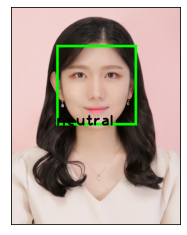

어떡하지 표정~

[{'box': array([279, 240, 500, 500]), 'emotions': {'angry': 0.0, 'disgust': 0.0, 'fear': 0.01, 'happy': 0.24, 'sad': 0.01, 'surprise': 0.0, 'neutral': 0.74}}]


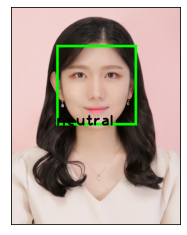

흐음

[{'box': array([279, 240, 500, 500]), 'emotions': {'angry': 0.0, 'disgust': 0.0, 'fear': 0.01, 'happy': 0.24, 'sad': 0.01, 'surprise': 0.0, 'neutral': 0.74}}]


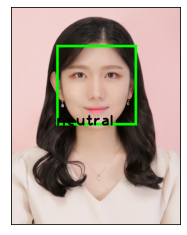

어떡하지 표정~

[{'box': array([144, 152, 394, 394]), 'emotions': {'angry': 0.02, 'disgust': 0.0, 'fear': 0.02, 'happy': 0.88, 'sad': 0.0, 'surprise': 0.01, 'neutral': 0.08}}]


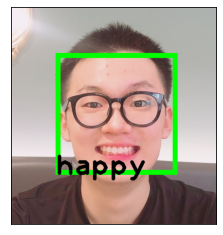

행복함의 부리부리~

[{'box': array([144, 152, 394, 394]), 'emotions': {'angry': 0.02, 'disgust': 0.0, 'fear': 0.02, 'happy': 0.88, 'sad': 0.0, 'surprise': 0.01, 'neutral': 0.08}}]


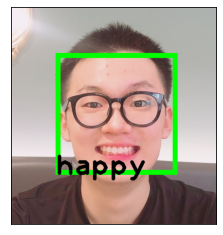

행복해

[{'box': array([ 35,  48, 200, 200]), 'emotions': {'angry': 0.0, 'disgust': 0.0, 'fear': 0.0, 'happy': 0.41, 'sad': 0.01, 'surprise': 0.04, 'neutral': 0.54}}]


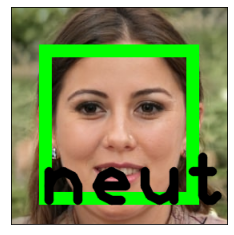

졸려

[{'box': array([ 36,  47, 196, 196]), 'emotions': {'angry': 0.0, 'disgust': 0.0, 'fear': 0.0, 'happy': 0.99, 'sad': 0.0, 'surprise': 0.0, 'neutral': 0.01}}]


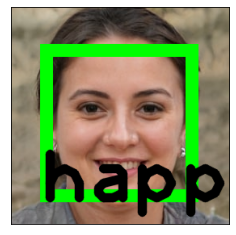

행복함의 부리부리~



In [40]:
for i in our_imgs:
    emotions = find_emotion(i)
    show_emo(emotions)
    print('')

## 시작~

In [15]:
model = torch.load("trained_model.pt", map_location=device)
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )


In [64]:
# 관심영역 지정
import cv2
import numpy as np
import matplotlib.pyplot as plt
from fer import FER
from PIL import ImageFont, ImageDraw, Image

def find_print_emotion(file_path):
    img = cv2.imread(file_path)
    detector = FER()

    # 이미지 감정 분류
    result = detector.detect_emotions(img)
    #print(result)
    
    # 가장 높은 점수를 기록한 감정
    emotion, score = detector.top_emotion(img)

    x = result[0]['box'][0]
    y = result[0]['box'][1] 
    w = result[0]['box'][2] 
    h = result[0]['box'][3]
    
    emo_dict = {'angry': '화남', 
            'disgust': '역겨움', 
            'fear': '두려움', 
            'happy': '행복', 
            'sad': '슬픔', 
            'surprise': '놀람', 
            'neutral': '중립'}
    # 한국어로 변경
    emo_kr = emo_dict[emotion]
    # roi 좌표
    roi = img[y:y+h, x:x+w]
    
    # roi 전체에 사각형 그리기
    if file_path in ['1.jpg', '2.jpg', '3.jpg']:
        cv2.rectangle(roi, (0,0), (h-1, w-1), (0,255,0), 30)
    
    else:
        cv2.rectangle(roi, (0,0), (h-1, w-1), (0,255,0), 30)
    
    '''
    # roi 전체에 사각형 그리기
    cv2.rectangle(roi, (0,0), (h-1, w-1), (0,255,0), 15)
    # cv2.putText(img, f'{emotion}', (x, y+h), cv2.FONT_HERSHEY_PLAIN, 3, (0,0,0), 5, cv2.LINE_AA)
    
    # roi 전체에 사각형 그리기
    cv2.rectangle(roi, (0,0), (h-1, w-1), (0,255,0), 30)
    cv2.putText(img, f'{emotion}', (x, y+h), cv2.FONT_HERSHEY_PLAIN, 6, (0,0,0), 10, cv2.LINE_AA)
    plt.imshow(img[:,:,(2,1,0)])
    plt.xticks([])
    plt.yticks([])
    plt.show() 
    '''
    
    ###############################################
    sent = "2" # 0=일상, 1=부정, 2=긍정
    with torch.no_grad():
        q = emo_kr # 저장된 감정을 input으로 
        a = ""
        
        while 1:
            input_ids = torch.LongTensor(koGPT2_TOKENIZER.encode(Q_TKN + q + SENT + sent + A_TKN + a)).unsqueeze(dim=0)

            # tensor cuda로 올리기
            input_ids = input_ids.cuda()

            pred = model(input_ids)
            pred = pred.logits.detach().cpu()
            gen = koGPT2_TOKENIZER.convert_ids_to_tokens(torch.argmax(pred, dim=-1).squeeze().numpy().tolist())[-1]
            if gen == EOS:
                break
            a += gen.replace("▁", " ")
        
        # GPT 모델이 만든 감정 문장
        final_emo = a.strip()
    #print(final_emo)
    
    # 한글 글씨 출력
    if file_path in ['1.jpg', '2.jpg', '3.jpg']:
        fontpath = "fonts/H2GTRE.TTF"
        font = ImageFont.truetype(fontpath, 40)
        img_pil = Image.fromarray(img)
        draw = ImageDraw.Draw(img_pil)
        draw.text((x, y+h),  final_emo, font=font, fill=(255,255,255,0))
        img = np.array(img_pil)
    else:
        fontpath = "fonts/H2GTRE.TTF"
        font = ImageFont.truetype(fontpath, 50)
        img_pil = Image.fromarray(img)
        draw = ImageDraw.Draw(img_pil)
        draw.text((x, y+h),  final_emo, font=font, fill=(255,255,255,0))
        img = np.array(img_pil)
    
    ax1 = plt.subplot(121)
    ax1.imshow(img[:,:,(2,1,0)])
    plt.xticks([])
    plt.yticks([])
    
    # 모델 생성 이미지에 한글 글씨 출력
    out_file_path = file_path[0]+'_'+file_path[0]+'.png'
    out_img = cv2.imread(out_file_path)
    # roi 좌표
    #out_roi = out_img[y:y+h, x:x+w]
    #cv2.rectangle(out_roi, (0,0), (h-1, w-1), (0,255,0), 15)
    
    # font
    out_img_pil = Image.fromarray(out_img)
    out_draw = ImageDraw.Draw(out_img_pil)
    out_draw.text((x, y+h),  final_emo, font=font, fill=(0,0,0,0))
    out_img = np.array(out_img_pil)
    
    ax2 = plt.subplot(122)
    ax2.imshow(out_img[:,:,(2,1,0)])
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [65]:
from glob import glob

our_imgs = glob('*.jpg')

In [66]:
our_imgs

['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg']

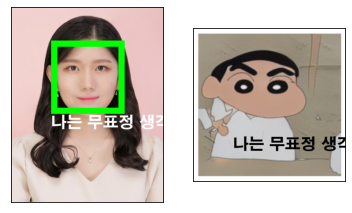

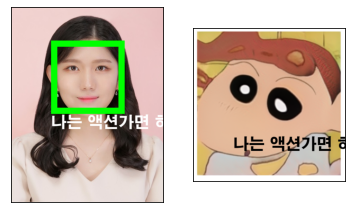

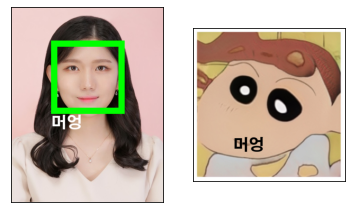

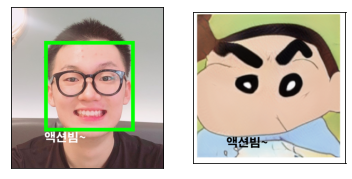

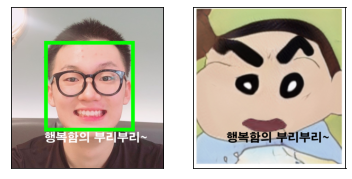

In [67]:
from glob import glob

# ffhg_imgs = glob('ffhq_*.png')

for i in our_imgs:
    find_print_emotion(i)